Code de simulation : Brinicle

In [1]:
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas

In [23]:
# Les fonctions utilisées :
"???????????????????????????????????????????????????????"
#
# =============================================================================
# Pour commencer il faut décrire les différents phénomènes qui rentrent en jeu :
#
# - Le déplacement de matière : il y a de la diffusion, de la convection, l'action du poids
# - Le déplacement de chaleur : par convection, par diffusion et par changement d'état
# - Des changements d'états


# Fonctions de déplacement d'éléments

def Depl_Vert(A,i,j): #déplacement vertical
    A[i+1][j]=A[i][j]
    return A

def Depl_D(A,i,j): #déplacement vers la droite
    A[i][j+1]=A[i][j]
    return A

def Depl_G(A,i,j): #déplacement vers la gauche
    A[i][j-1]=A[i][j]
    return A



# Pour pouvoir caractériser les déplacements de matières, de chaleur, et les
# changements d'état on utilise un tableau qui contient des triplets
# Le premier élément du triplet contient la présence ou non d'eau, le deuxième
# élément contient la température de l'élément, le troisième l'état
# physique de l'élément

# Légende :
# 1er triplet :
# 0 si il n'y a pas d'eau
# 1 si il y a de l'eau
#
# 2ème triplet :
# Température
#
# 3ème triplet :
# G si l'eau est sous forme glace
# L si l'eau est liquide pure
# B si l'eau est liquide très salée (saumure)

#A=[[[1,0,'L'],[1,0,'L'],[1,0,'G'],[1,0,'L']],[[1,1,'L'],[1,1,'L'],[1,0,'L'],[1,0,'L']],[[1,2,'L'],[1,2,'L'],[1,2,'L'],[1,2,'L']],[[1,2,'L'],[1,2,'L'],[1,2,'L'],[1,2,'L']]]


# Fonctions de déplacement de chaleur

# On modélise le déplacement de chaleur avec :
# Le modèle de Newton (conducto-convection) pour les transferts entre la glace et
# l'eau et l'eau salée et l'eau

def Conducto_Conv(A,i,j,hcc=10**-3,l=1):
    L=[0,0]
    n = len(A)
    if j == 0:
        L[1] = hcc*l**2*(A[i][j][0]-A[i][j+1][1])
    elif j == n-1:
        L[0] = hcc*(A[i][j][0]-A[i][j-1][1])*l**2
    else :
        L[1] = hcc*(A[i][j][0]-A[i][j+1][1])*l**2
        L[0] = hcc*(A[i][j][0]-A[i][j-1][1])*l**2
    return L

# Les transferts thermiques diffusifs entre 2 éléments de température différente
# Les effets convectifs sont inclus dans le déplacement d'éléments (les particules
# se déplacent avec leurs caractéristiques) et ne concernent que le cylindre

def Diff_Th(A,i,j,lbda = -0.6): 
    L = 0
    n = len(A)
    if i == 0 and j ==0:
        L = lbda*(A[i][j][0]-A[i+1][j][0])/1 + lbda*(A[i][j][0]-A[i][j+1][0])/1
    elif i == 0 and j == n-1:
        L = lbda*(A[i][j][0]-A[i+1][j][0])/1 + lbda*(A[i][j][0]-A[i][j-1][0])/1
    elif i == n-1 and j == 0:
        L = lbda*(A[i][j][0]-A[i-1][j][0])/1 + lbda*(A[i][j][0]-A[i][j+1][0])/1
    elif i == n-1 and j == n-1:
        L = lbda*(A[i][j][0]-A[i-1][j][0])/1 + lbda*(A[i][j][0]-A[i][j-1][0])/1
    elif i == 0:
        L = lbda*(A[i][j][0]-A[i+1][j][0])/1 + lbda*(A[i][j][0]-A[i][j+1][0])/1 + lbda*(A[i][j][0]-A[i][j-1][0])/1
    elif i == n-1:
        L = lbda*(A[i][j][0]-A[i-1][j][0])/1 + lbda*(A[i][j][0]-A[i][j+1][0])/1 + lbda*(A[i][j][0]-A[i][j-1][0])/1
    elif j == 0:
        L = lbda*(A[i][j][0]-A[i+1][j][0])/1 + lbda*(A[i][j][0]-A[i][j+1][0])/1 + lbda*(A[i][j][0]-A[i-1][j][0])/1
    elif j == n-1:
        L = lbda*(A[i][j][0]-A[i+1][j][0])/1 + lbda*(A[i][j][0]-A[i][j-1][0])/1 + lbda*(A[i][j][0]-A[i-1][j][0])/1
    else:
        L = lbda*(A[i][j][0]-A[i+1][j][0])/1 + lbda*(A[i][j][0]-A[i][j+1][0])/1 + lbda*(A[i][j][0]-A[i][j-1][0])/1 + lbda*(A[i][j][0]-A[i-1][j][0])/1
    return L

# Fonctions de changement d'état
# On a plusieurs types de changement d'état, la solidification de l'eau,
# La liquéfaction de la glace, la salinisation de l'eau liquide, la dessalinisation
# de l'eau salée

# Les transformations que l'on considère sont :
# La solidification
def Solidification(A,i,j):
    A[i][j][1]='G'

# La liquéfaction
def Liquéfaction(A,i,j):
    A[i][j][1]='L'

# La salinisation
def Salinisation(A,i,j):
    A[i][j][1]='B'

# On considère donc qu'une fois que l'eau est salinisée elle ne peut plus être dessalinisée (première hypothèse)

def Evo(A,eps=0.001, c_eau_liquide = 4180, c_glace = 2100, c_eau_salee = 3900):
    n=len(A)
    [A,Q_matrice] = ChgtEtat(A, eps)
    for i in range(n):
        for j in range(n):
            Q = Diff_Th(A,i,j) + Q_matrice[i][j] #Q, transfert thermique
            Tij=A[i][j][0] #temperature position i,j
            if A[i][j][1] == 'L':
                Tij += Q/c_eau_liquide
            elif A[i][j][1] == 'G':
                Tij += Q/c_glace
            elif A[i][j][1] == 'B':
                Tij += Q/c_eau_salee
            A[i][j][0] = Tij
    
    A = descente_B(A)
    return A #return A modifié pour chaques positions i,j en fonction de Q

#%% CHANGEMENT D'ETAT

def ChgtEtat(A,eps=0.001, dtau = 0.005, Lfus = 3.34E5):
    n=len(A)
    Q=[[0 for i in range(n)]for j in range(n)]
    for i in range(n):
        for j in range(n):
            if A[i][j][0]<-eps and A[i][j][1] == 'L': #si T petit (<-eps) et liquide
                A[i][j][1] = 'G'                     #alors ça devient de la glace
                Q[i][j] = -Lfus*dtau                 
            elif A[i][j][0]>eps and A[i][j][1] == 'G' : #sinon si c'est de la glace et la temperature est >eps
                A[i][j][1] = 'L'                        #alors ca devient liquide
                Q[i][j] = Lfus*dtau

    return [A,Q]

def descente_B(A,eps=0.001, dtau = 0.005, Lfus = 3.34E5):
    n=len(A)
    for i in range(n-1):
        for j in range(n):
            if A[i][j][1] == 'B':
                A[i+1][j][1] = 'B'
                A[i+1][j][0] = A[i][j][0]
    return A


def simulation_jolie(A, disp = "State"):
    n = len(A) 
    for k in range(1000):
        A = Evo(A)
        #show matrix
        for i in range(n):
            for j in range(n):
                if disp == "State" and k%50==0:
                    ax = plt.gca()
                    # change figure axis x to 0 to 3 and y to 0 to 3
                    ax.set_xlim(0, n)
                    ax.set_ylim(0, n)
                    ax.imshow([[A[i][j][0] for j in range(len(A))] for i in range(len(A))], cmap='hot', interpolation='nearest')
                    if A[i][j][1] == 'G':
                        ax.add_patch(plt.Rectangle((n-1-j, n-1-i), 1, 1, fill=True, color='cyan'))
                    elif A[i][j][1] == 'L':
                        ax.add_patch(plt.Rectangle((n-1-j, n-1-i), 1, 1, fill=True, color='blue'))
                    elif A[i][j][1] == 'B':
                        ax.add_patch(plt.Rectangle((n-1-j, n-1-i), 1, 1, fill=True, color='green'))
                elif disp=="Temperature" and k%50==0:
                    df = pandas.DataFrame(A)
                    display(df)
        if disp == "State" and k%50==0:
            plt.pause(0.1)
            plt.show()  


In [9]:
A = [[[-1,'G'],[-3,'B'],[-1,'G']],
     [[-0.05,'G'],[-0.05,'G'],[-0.05,'G']],
     [[0,'L'],[0,'L'],[0,'L']]]

simulation_jolie(A, disp = "Temperature")

,0,1,2
0,"[-1.0003, G]","[-2.9989308153846155, B]","[-1.0002996945186813, G]"
1,"[-0.05025722857142857, G]","[-2.9989308153846155, B]","[-0.05025746515255995, G]"
2,"[-7.213956254272044e-06, L]","[-2.9989308153846155, B]","[-7.215037625159876e-06, L]"


,0,1,2
0,"[-1.0003, G]","[-2.9989308153846155, B]","[-1.0002996945186813, G]"
1,"[-0.05025722857142857, G]","[-2.9989308153846155, B]","[-0.05025746515255995, G]"
2,"[-7.213956254272044e-06, L]","[-2.9989308153846155, B]","[-7.215037625159876e-06, L]"


,0,1,2
0,"[-1.0003, G]","[-2.9989308153846155, B]","[-1.0002996945186813, G]"
1,"[-0.05025722857142857, G]","[-2.9989308153846155, B]","[-0.05025746515255995, G]"
2,"[-7.213956254272044e-06, L]","[-2.9989308153846155, B]","[-7.215037625159876e-06, L]"


,0,1,2
0,"[-1.0003, G]","[-2.9989308153846155, B]","[-1.0002996945186813, G]"
1,"[-0.05025722857142857, G]","[-2.9989308153846155, B]","[-0.05025746515255995, G]"
2,"[-7.213956254272044e-06, L]","[-2.9989308153846155, B]","[-7.215037625159876e-06, L]"


,0,1,2
0,"[-1.0003, G]","[-2.9989308153846155, B]","[-1.0002996945186813, G]"
1,"[-0.05025722857142857, G]","[-2.9989308153846155, B]","[-0.05025746515255995, G]"
2,"[-7.213956254272044e-06, L]","[-2.9989308153846155, B]","[-7.215037625159876e-06, L]"


,0,1,2
0,"[-1.0003, G]","[-2.9989308153846155, B]","[-1.0002996945186813, G]"
1,"[-0.05025722857142857, G]","[-2.9989308153846155, B]","[-0.05025746515255995, G]"
2,"[-7.213956254272044e-06, L]","[-2.9989308153846155, B]","[-7.215037625159876e-06, L]"


,0,1,2
0,"[-1.0003, G]","[-2.9989308153846155, B]","[-1.0002996945186813, G]"
1,"[-0.05025722857142857, G]","[-2.9989308153846155, B]","[-0.05025746515255995, G]"
2,"[-7.213956254272044e-06, L]","[-2.9989308153846155, B]","[-7.215037625159876e-06, L]"


,0,1,2
0,"[-1.0003, G]","[-2.9989308153846155, B]","[-1.0002996945186813, G]"
1,"[-0.05025722857142857, G]","[-2.9989308153846155, B]","[-0.05025746515255995, G]"
2,"[-7.213956254272044e-06, L]","[-2.9989308153846155, B]","[-7.215037625159876e-06, L]"


,0,1,2
0,"[-1.0003, G]","[-2.9989308153846155, B]","[-1.0002996945186813, G]"
1,"[-0.05025722857142857, G]","[-2.9989308153846155, B]","[-0.05025746515255995, G]"
2,"[-7.213956254272044e-06, L]","[-2.9989308153846155, B]","[-7.215037625159876e-06, L]"


,0,1,2
0,"[-1.0005995965839873, G]","[-2.99831589810159, B]","[-1.0005991156541718, G]"
1,"[-0.051356875982917306, G]","[-2.99831589810159, B]","[-0.051356853021430934, G]"
2,"[-0.0004450522237358545, L]","[-2.99831589810159, B]","[-0.00044492083959594595, L]"


,0,1,2
0,"[-1.0005995965839873, G]","[-2.99831589810159, B]","[-1.0005991156541718, G]"
1,"[-0.051356875982917306, G]","[-2.99831589810159, B]","[-0.051356853021430934, G]"
2,"[-0.0004450522237358545, L]","[-2.99831589810159, B]","[-0.00044492083959594595, L]"


,0,1,2
0,"[-1.0005995965839873, G]","[-2.99831589810159, B]","[-1.0005991156541718, G]"
1,"[-0.051356875982917306, G]","[-2.99831589810159, B]","[-0.051356853021430934, G]"
2,"[-0.0004450522237358545, L]","[-2.99831589810159, B]","[-0.00044492083959594595, L]"


,0,1,2
0,"[-1.0005995965839873, G]","[-2.99831589810159, B]","[-1.0005991156541718, G]"
1,"[-0.051356875982917306, G]","[-2.99831589810159, B]","[-0.051356853021430934, G]"
2,"[-0.0004450522237358545, L]","[-2.99831589810159, B]","[-0.00044492083959594595, L]"


,0,1,2
0,"[-1.0005995965839873, G]","[-2.99831589810159, B]","[-1.0005991156541718, G]"
1,"[-0.051356875982917306, G]","[-2.99831589810159, B]","[-0.051356853021430934, G]"
2,"[-0.0004450522237358545, L]","[-2.99831589810159, B]","[-0.00044492083959594595, L]"


,0,1,2
0,"[-1.0005995965839873, G]","[-2.99831589810159, B]","[-1.0005991156541718, G]"
1,"[-0.051356875982917306, G]","[-2.99831589810159, B]","[-0.051356853021430934, G]"
2,"[-0.0004450522237358545, L]","[-2.99831589810159, B]","[-0.00044492083959594595, L]"


,0,1,2
0,"[-1.0005995965839873, G]","[-2.99831589810159, B]","[-1.0005991156541718, G]"
1,"[-0.051356875982917306, G]","[-2.99831589810159, B]","[-0.051356853021430934, G]"
2,"[-0.0004450522237358545, L]","[-2.99831589810159, B]","[-0.00044492083959594595, L]"


,0,1,2
0,"[-1.0005995965839873, G]","[-2.99831589810159, B]","[-1.0005991156541718, G]"
1,"[-0.051356875982917306, G]","[-2.99831589810159, B]","[-0.051356853021430934, G]"
2,"[-0.0004450522237358545, L]","[-2.99831589810159, B]","[-0.00044492083959594595, L]"


,0,1,2
0,"[-1.0005995965839873, G]","[-2.99831589810159, B]","[-1.0005991156541718, G]"
1,"[-0.051356875982917306, G]","[-2.99831589810159, B]","[-0.051356853021430934, G]"
2,"[-0.0004450522237358545, L]","[-2.99831589810159, B]","[-0.00044492083959594595, L]"


,0,1,2
0,"[-1.0008991604642492, G]","[-2.997701262175423, B]","[-1.0008985041924257, G]"
1,"[-0.052455615835157544, G]","[-2.997701262175423, B]","[-0.05245533361626554, G]"
2,"[-0.0008828342442367073, L]","[-2.997701262175423, B]","[-0.0008825704419042576, L]"


,0,1,2
0,"[-1.0008991604642492, G]","[-2.997701262175423, B]","[-1.0008985041924257, G]"
1,"[-0.052455615835157544, G]","[-2.997701262175423, B]","[-0.05245533361626554, G]"
2,"[-0.0008828342442367073, L]","[-2.997701262175423, B]","[-0.0008825704419042576, L]"


,0,1,2
0,"[-1.0008991604642492, G]","[-2.997701262175423, B]","[-1.0008985041924257, G]"
1,"[-0.052455615835157544, G]","[-2.997701262175423, B]","[-0.05245533361626554, G]"
2,"[-0.0008828342442367073, L]","[-2.997701262175423, B]","[-0.0008825704419042576, L]"


,0,1,2
0,"[-1.0008991604642492, G]","[-2.997701262175423, B]","[-1.0008985041924257, G]"
1,"[-0.052455615835157544, G]","[-2.997701262175423, B]","[-0.05245533361626554, G]"
2,"[-0.0008828342442367073, L]","[-2.997701262175423, B]","[-0.0008825704419042576, L]"


,0,1,2
0,"[-1.0008991604642492, G]","[-2.997701262175423, B]","[-1.0008985041924257, G]"
1,"[-0.052455615835157544, G]","[-2.997701262175423, B]","[-0.05245533361626554, G]"
2,"[-0.0008828342442367073, L]","[-2.997701262175423, B]","[-0.0008825704419042576, L]"


,0,1,2
0,"[-1.0008991604642492, G]","[-2.997701262175423, B]","[-1.0008985041924257, G]"
1,"[-0.052455615835157544, G]","[-2.997701262175423, B]","[-0.05245533361626554, G]"
2,"[-0.0008828342442367073, L]","[-2.997701262175423, B]","[-0.0008825704419042576, L]"


,0,1,2
0,"[-1.0008991604642492, G]","[-2.997701262175423, B]","[-1.0008985041924257, G]"
1,"[-0.052455615835157544, G]","[-2.997701262175423, B]","[-0.05245533361626554, G]"
2,"[-0.0008828342442367073, L]","[-2.997701262175423, B]","[-0.0008825704419042576, L]"


,0,1,2
0,"[-1.0008991604642492, G]","[-2.997701262175423, B]","[-1.0008985041924257, G]"
1,"[-0.052455615835157544, G]","[-2.997701262175423, B]","[-0.05245533361626554, G]"
2,"[-0.0008828342442367073, L]","[-2.997701262175423, B]","[-0.0008825704419042576, L]"


,0,1,2
0,"[-1.0008991604642492, G]","[-2.997701262175423, B]","[-1.0008985041924257, G]"
1,"[-0.052455615835157544, G]","[-2.997701262175423, B]","[-0.05245533361626554, G]"
2,"[-0.0008828342442367073, L]","[-2.997701262175423, B]","[-0.0008825704419042576, L]"


,0,1,2
0,"[-1.0011986914805584, G]","[-2.9970869075094724, B]","[-1.0011978599732088, G]"
1,"[-0.053553448960984615, G]","[-2.9970869075094724, B]","[-0.05355290776959411, G]"
2,"[-0.0013205599441383246, L]","[-2.9970869075094724, B]","[-0.0013201637709439808, L]"


,0,1,2
0,"[-1.0011986914805584, G]","[-2.9970869075094724, B]","[-1.0011978599732088, G]"
1,"[-0.053553448960984615, G]","[-2.9970869075094724, B]","[-0.05355290776959411, G]"
2,"[-0.0013205599441383246, L]","[-2.9970869075094724, B]","[-0.0013201637709439808, L]"


,0,1,2
0,"[-1.0011986914805584, G]","[-2.9970869075094724, B]","[-1.0011978599732088, G]"
1,"[-0.053553448960984615, G]","[-2.9970869075094724, B]","[-0.05355290776959411, G]"
2,"[-0.0013205599441383246, L]","[-2.9970869075094724, B]","[-0.0013201637709439808, L]"


,0,1,2
0,"[-1.0011986914805584, G]","[-2.9970869075094724, B]","[-1.0011978599732088, G]"
1,"[-0.053553448960984615, G]","[-2.9970869075094724, B]","[-0.05355290776959411, G]"
2,"[-0.0013205599441383246, L]","[-2.9970869075094724, B]","[-0.0013201637709439808, L]"


,0,1,2
0,"[-1.0011986914805584, G]","[-2.9970869075094724, B]","[-1.0011978599732088, G]"
1,"[-0.053553448960984615, G]","[-2.9970869075094724, B]","[-0.05355290776959411, G]"
2,"[-0.0013205599441383246, L]","[-2.9970869075094724, B]","[-0.0013201637709439808, L]"


,0,1,2
0,"[-1.0011986914805584, G]","[-2.9970869075094724, B]","[-1.0011978599732088, G]"
1,"[-0.053553448960984615, G]","[-2.9970869075094724, B]","[-0.05355290776959411, G]"
2,"[-0.0013205599441383246, L]","[-2.9970869075094724, B]","[-0.0013201637709439808, L]"


,0,1,2
0,"[-1.0011986914805584, G]","[-2.9970869075094724, B]","[-1.0011978599732088, G]"
1,"[-0.053553448960984615, G]","[-2.9970869075094724, B]","[-0.05355290776959411, G]"
2,"[-0.0013205599441383246, L]","[-2.9970869075094724, B]","[-0.0013201637709439808, L]"


,0,1,2
0,"[-1.0011986914805584, G]","[-2.9970869075094724, B]","[-1.0011978599732088, G]"
1,"[-0.053553448960984615, G]","[-2.9970869075094724, B]","[-0.05355290776959411, G]"
2,"[-0.0013205599441383246, L]","[-2.9970869075094724, B]","[-0.0013201637709439808, L]"


,0,1,2
0,"[-1.0011986914805584, G]","[-2.9970869075094724, B]","[-1.0011978599732088, G]"
1,"[-0.053553448960984615, G]","[-2.9970869075094724, B]","[-0.05355290776959411, G]"
2,"[-0.0013205599441383246, L]","[-2.9970869075094724, B]","[-0.0013201637709439808, L]"


,0,1,2
0,"[-1.0014981894729897, G]","[-2.9964728340070765, B]","[-1.0014971828365888, G]"
1,"[-0.05465037619242566, G]","[-2.9964728340070765, B]","[-0.05464957631313911, G]"
2,"[-0.7974298255147518, G]","[-2.9964728340070765, B]","[-0.7974292009293193, G]"


,0,1,2
0,"[-1.0014981894729897, G]","[-2.9964728340070765, B]","[-1.0014971828365888, G]"
1,"[-0.05465037619242566, G]","[-2.9964728340070765, B]","[-0.05464957631313911, G]"
2,"[-0.7974298255147518, G]","[-2.9964728340070765, B]","[-0.7974292009293193, G]"


,0,1,2
0,"[-1.0014981894729897, G]","[-2.9964728340070765, B]","[-1.0014971828365888, G]"
1,"[-0.05465037619242566, G]","[-2.9964728340070765, B]","[-0.05464957631313911, G]"
2,"[-0.7974298255147518, G]","[-2.9964728340070765, B]","[-0.7974292009293193, G]"


,0,1,2
0,"[-1.0014981894729897, G]","[-2.9964728340070765, B]","[-1.0014971828365888, G]"
1,"[-0.05465037619242566, G]","[-2.9964728340070765, B]","[-0.05464957631313911, G]"
2,"[-0.7974298255147518, G]","[-2.9964728340070765, B]","[-0.7974292009293193, G]"


,0,1,2
0,"[-1.0014981894729897, G]","[-2.9964728340070765, B]","[-1.0014971828365888, G]"
1,"[-0.05465037619242566, G]","[-2.9964728340070765, B]","[-0.05464957631313911, G]"
2,"[-0.7974298255147518, G]","[-2.9964728340070765, B]","[-0.7974292009293193, G]"


,0,1,2
0,"[-1.0014981894729897, G]","[-2.9964728340070765, B]","[-1.0014971828365888, G]"
1,"[-0.05465037619242566, G]","[-2.9964728340070765, B]","[-0.05464957631313911, G]"
2,"[-0.7974298255147518, G]","[-2.9964728340070765, B]","[-0.7974292009293193, G]"


,0,1,2
0,"[-1.0014981894729897, G]","[-2.9964728340070765, B]","[-1.0014971828365888, G]"
1,"[-0.05465037619242566, G]","[-2.9964728340070765, B]","[-0.05464957631313911, G]"
2,"[-0.7974298255147518, G]","[-2.9964728340070765, B]","[-0.7974292009293193, G]"


,0,1,2
0,"[-1.0014981894729897, G]","[-2.9964728340070765, B]","[-1.0014971828365888, G]"
1,"[-0.05465037619242566, G]","[-2.9964728340070765, B]","[-0.05464957631313911, G]"
2,"[-0.7974298255147518, G]","[-2.9964728340070765, B]","[-0.7974292009293193, G]"


,0,1,2
0,"[-1.0014981894729897, G]","[-2.9964728340070765, B]","[-1.0014971828365888, G]"
1,"[-0.05465037619242566, G]","[-2.9964728340070765, B]","[-0.05464957631313911, G]"
2,"[-0.7974298255147518, G]","[-2.9964728340070765, B]","[-0.7974292009293193, G]"


,0,1,2
0,"[-1.0017976542819194, G]","[-2.995859041571554, B]","[-1.001796472622935, G]"
1,"[-0.05597373310249037, G]","[-2.995859041571554, B]","[-0.05597267480214475, G]"
2,"[-0.7978462789193461, G]","[-2.995859041571554, B]","[-0.7978454610444808, G]"


,0,1,2
0,"[-1.0017976542819194, G]","[-2.995859041571554, B]","[-1.001796472622935, G]"
1,"[-0.05597373310249037, G]","[-2.995859041571554, B]","[-0.05597267480214475, G]"
2,"[-0.7978462789193461, G]","[-2.995859041571554, B]","[-0.7978454610444808, G]"


,0,1,2
0,"[-1.0017976542819194, G]","[-2.995859041571554, B]","[-1.001796472622935, G]"
1,"[-0.05597373310249037, G]","[-2.995859041571554, B]","[-0.05597267480214475, G]"
2,"[-0.7978462789193461, G]","[-2.995859041571554, B]","[-0.7978454610444808, G]"


,0,1,2
0,"[-1.0017976542819194, G]","[-2.995859041571554, B]","[-1.001796472622935, G]"
1,"[-0.05597373310249037, G]","[-2.995859041571554, B]","[-0.05597267480214475, G]"
2,"[-0.7978462789193461, G]","[-2.995859041571554, B]","[-0.7978454610444808, G]"


,0,1,2
0,"[-1.0017976542819194, G]","[-2.995859041571554, B]","[-1.001796472622935, G]"
1,"[-0.05597373310249037, G]","[-2.995859041571554, B]","[-0.05597267480214475, G]"
2,"[-0.7978462789193461, G]","[-2.995859041571554, B]","[-0.7978454610444808, G]"


,0,1,2
0,"[-1.0017976542819194, G]","[-2.995859041571554, B]","[-1.001796472622935, G]"
1,"[-0.05597373310249037, G]","[-2.995859041571554, B]","[-0.05597267480214475, G]"
2,"[-0.7978462789193461, G]","[-2.995859041571554, B]","[-0.7978454610444808, G]"


,0,1,2
0,"[-1.0017976542819194, G]","[-2.995859041571554, B]","[-1.001796472622935, G]"
1,"[-0.05597373310249037, G]","[-2.995859041571554, B]","[-0.05597267480214475, G]"
2,"[-0.7978462789193461, G]","[-2.995859041571554, B]","[-0.7978454610444808, G]"


,0,1,2
0,"[-1.0017976542819194, G]","[-2.995859041571554, B]","[-1.001796472622935, G]"
1,"[-0.05597373310249037, G]","[-2.995859041571554, B]","[-0.05597267480214475, G]"
2,"[-0.7978462789193461, G]","[-2.995859041571554, B]","[-0.7978454610444808, G]"


,0,1,2
0,"[-1.0017976542819194, G]","[-2.995859041571554, B]","[-1.001796472622935, G]"
1,"[-0.05597373310249037, G]","[-2.995859041571554, B]","[-0.05597267480214475, G]"
2,"[-0.7978462789193461, G]","[-2.995859041571554, B]","[-0.7978454610444808, G]"


,0,1,2
0,"[-1.002097150700808, G]","[-2.9952455301161973, B]","[-1.0020957941256985, G]"
1,"[-0.057295984894457294, G]","[-2.9952455301161973, B]","[-0.057294668459606055, G]"
2,"[-0.7982626967675254, G]","[-2.9952455301161973, B]","[-0.7982616857305128, G]"


,0,1,2
0,"[-1.002097150700808, G]","[-2.9952455301161973, B]","[-1.0020957941256985, G]"
1,"[-0.057295984894457294, G]","[-2.9952455301161973, B]","[-0.057294668459606055, G]"
2,"[-0.7982626967675254, G]","[-2.9952455301161973, B]","[-0.7982616857305128, G]"


,0,1,2
0,"[-1.002097150700808, G]","[-2.9952455301161973, B]","[-1.0020957941256985, G]"
1,"[-0.057295984894457294, G]","[-2.9952455301161973, B]","[-0.057294668459606055, G]"
2,"[-0.7982626967675254, G]","[-2.9952455301161973, B]","[-0.7982616857305128, G]"


,0,1,2
0,"[-1.002097150700808, G]","[-2.9952455301161973, B]","[-1.0020957941256985, G]"
1,"[-0.057295984894457294, G]","[-2.9952455301161973, B]","[-0.057294668459606055, G]"
2,"[-0.7982626967675254, G]","[-2.9952455301161973, B]","[-0.7982616857305128, G]"


,0,1,2
0,"[-1.002097150700808, G]","[-2.9952455301161973, B]","[-1.0020957941256985, G]"
1,"[-0.057295984894457294, G]","[-2.9952455301161973, B]","[-0.057294668459606055, G]"
2,"[-0.7982626967675254, G]","[-2.9952455301161973, B]","[-0.7982616857305128, G]"


,0,1,2
0,"[-1.002097150700808, G]","[-2.9952455301161973, B]","[-1.0020957941256985, G]"
1,"[-0.057295984894457294, G]","[-2.9952455301161973, B]","[-0.057294668459606055, G]"
2,"[-0.7982626967675254, G]","[-2.9952455301161973, B]","[-0.7982616857305128, G]"


,0,1,2
0,"[-1.002097150700808, G]","[-2.9952455301161973, B]","[-1.0020957941256985, G]"
1,"[-0.057295984894457294, G]","[-2.9952455301161973, B]","[-0.057294668459606055, G]"
2,"[-0.7982626967675254, G]","[-2.9952455301161973, B]","[-0.7982616857305128, G]"


,0,1,2
0,"[-1.002097150700808, G]","[-2.9952455301161973, B]","[-1.0020957941256985, G]"
1,"[-0.057295984894457294, G]","[-2.9952455301161973, B]","[-0.057294668459606055, G]"
2,"[-0.7982626967675254, G]","[-2.9952455301161973, B]","[-0.7982616857305128, G]"


,0,1,2
0,"[-1.002097150700808, G]","[-2.9952455301161973, B]","[-1.0020957941256985, G]"
1,"[-0.057295984894457294, G]","[-2.9952455301161973, B]","[-0.057294668459606055, G]"
2,"[-0.7982626967675254, G]","[-2.9952455301161973, B]","[-0.7982616857305128, G]"


,0,1,2
0,"[-1.002396678476125, G]","[-2.994632299564254, B]","[-1.0023951470913477, G]"
1,"[-0.058617132594650574, G]","[-2.994632299564254, B]","[-0.05861555831154651, G]"
2,"[-0.7986790788444328, G]","[-2.994632299564254, B]","[-0.7986778747725397, G]"


,0,1,2
0,"[-1.002396678476125, G]","[-2.994632299564254, B]","[-1.0023951470913477, G]"
1,"[-0.058617132594650574, G]","[-2.994632299564254, B]","[-0.05861555831154651, G]"
2,"[-0.7986790788444328, G]","[-2.994632299564254, B]","[-0.7986778747725397, G]"


,0,1,2
0,"[-1.002396678476125, G]","[-2.994632299564254, B]","[-1.0023951470913477, G]"
1,"[-0.058617132594650574, G]","[-2.994632299564254, B]","[-0.05861555831154651, G]"
2,"[-0.7986790788444328, G]","[-2.994632299564254, B]","[-0.7986778747725397, G]"


,0,1,2
0,"[-1.002396678476125, G]","[-2.994632299564254, B]","[-1.0023951470913477, G]"
1,"[-0.058617132594650574, G]","[-2.994632299564254, B]","[-0.05861555831154651, G]"
2,"[-0.7986790788444328, G]","[-2.994632299564254, B]","[-0.7986778747725397, G]"


,0,1,2
0,"[-1.002396678476125, G]","[-2.994632299564254, B]","[-1.0023951470913477, G]"
1,"[-0.058617132594650574, G]","[-2.994632299564254, B]","[-0.05861555831154651, G]"
2,"[-0.7986790788444328, G]","[-2.994632299564254, B]","[-0.7986778747725397, G]"


,0,1,2
0,"[-1.002396678476125, G]","[-2.994632299564254, B]","[-1.0023951470913477, G]"
1,"[-0.058617132594650574, G]","[-2.994632299564254, B]","[-0.05861555831154651, G]"
2,"[-0.7986790788444328, G]","[-2.994632299564254, B]","[-0.7986778747725397, G]"


,0,1,2
0,"[-1.002396678476125, G]","[-2.994632299564254, B]","[-1.0023951470913477, G]"
1,"[-0.058617132594650574, G]","[-2.994632299564254, B]","[-0.05861555831154651, G]"
2,"[-0.7986790788444328, G]","[-2.994632299564254, B]","[-0.7986778747725397, G]"


,0,1,2
0,"[-1.002396678476125, G]","[-2.994632299564254, B]","[-1.0023951470913477, G]"
1,"[-0.058617132594650574, G]","[-2.994632299564254, B]","[-0.05861555831154651, G]"
2,"[-0.7986790788444328, G]","[-2.994632299564254, B]","[-0.7986778747725397, G]"


,0,1,2
0,"[-1.002396678476125, G]","[-2.994632299564254, B]","[-1.0023951470913477, G]"
1,"[-0.058617132594650574, G]","[-2.994632299564254, B]","[-0.05861555831154651, G]"
2,"[-0.7986790788444328, G]","[-2.994632299564254, B]","[-0.7986778747725397, G]"


,0,1,2
0,"[-1.0026962373547554, G]","[-2.9940193498389185, B]","[-1.002694531266767, G]"
1,"[-0.059937177228359, G]","[-2.9940193498389185, B]","[-0.05993534538295463, G]"
2,"[-0.7990954249356053, G]","[-2.9940193498389185, B]","[-0.7990940279560796, G]"


,0,1,2
0,"[-1.0026962373547554, G]","[-2.9940193498389185, B]","[-1.002694531266767, G]"
1,"[-0.059937177228359, G]","[-2.9940193498389185, B]","[-0.05993534538295463, G]"
2,"[-0.7990954249356053, G]","[-2.9940193498389185, B]","[-0.7990940279560796, G]"


,0,1,2
0,"[-1.0026962373547554, G]","[-2.9940193498389185, B]","[-1.002694531266767, G]"
1,"[-0.059937177228359, G]","[-2.9940193498389185, B]","[-0.05993534538295463, G]"
2,"[-0.7990954249356053, G]","[-2.9940193498389185, B]","[-0.7990940279560796, G]"


,0,1,2
0,"[-1.0026962373547554, G]","[-2.9940193498389185, B]","[-1.002694531266767, G]"
1,"[-0.059937177228359, G]","[-2.9940193498389185, B]","[-0.05993534538295463, G]"
2,"[-0.7990954249356053, G]","[-2.9940193498389185, B]","[-0.7990940279560796, G]"


,0,1,2
0,"[-1.0026962373547554, G]","[-2.9940193498389185, B]","[-1.002694531266767, G]"
1,"[-0.059937177228359, G]","[-2.9940193498389185, B]","[-0.05993534538295463, G]"
2,"[-0.7990954249356053, G]","[-2.9940193498389185, B]","[-0.7990940279560796, G]"


,0,1,2
0,"[-1.0026962373547554, G]","[-2.9940193498389185, B]","[-1.002694531266767, G]"
1,"[-0.059937177228359, G]","[-2.9940193498389185, B]","[-0.05993534538295463, G]"
2,"[-0.7990954249356053, G]","[-2.9940193498389185, B]","[-0.7990940279560796, G]"


,0,1,2
0,"[-1.0026962373547554, G]","[-2.9940193498389185, B]","[-1.002694531266767, G]"
1,"[-0.059937177228359, G]","[-2.9940193498389185, B]","[-0.05993534538295463, G]"
2,"[-0.7990954249356053, G]","[-2.9940193498389185, B]","[-0.7990940279560796, G]"


,0,1,2
0,"[-1.0026962373547554, G]","[-2.9940193498389185, B]","[-1.002694531266767, G]"
1,"[-0.059937177228359, G]","[-2.9940193498389185, B]","[-0.05993534538295463, G]"
2,"[-0.7990954249356053, G]","[-2.9940193498389185, B]","[-0.7990940279560796, G]"


,0,1,2
0,"[-1.0026962373547554, G]","[-2.9940193498389185, B]","[-1.002694531266767, G]"
1,"[-0.059937177228359, G]","[-2.9940193498389185, B]","[-0.05993534538295463, G]"
2,"[-0.7990954249356053, G]","[-2.9940193498389185, B]","[-0.7990940279560796, G]"


,0,1,2
0,"[-1.0029958270840005, G]","[-2.9934066808633295, B]","[-1.0029939463992563, G]"
1,"[-0.061256119819837127, G]","[-2.9934066808633295, B]","[-0.061254030697785025, G]"
2,"[-0.7995117348269731, G]","[-2.9934066808633295, B]","[-0.7995101450670439, G]"


,0,1,2
0,"[-1.0029958270840005, G]","[-2.9934066808633295, B]","[-1.0029939463992563, G]"
1,"[-0.061256119819837127, G]","[-2.9934066808633295, B]","[-0.061254030697785025, G]"
2,"[-0.7995117348269731, G]","[-2.9934066808633295, B]","[-0.7995101450670439, G]"


,0,1,2
0,"[-1.0029958270840005, G]","[-2.9934066808633295, B]","[-1.0029939463992563, G]"
1,"[-0.061256119819837127, G]","[-2.9934066808633295, B]","[-0.061254030697785025, G]"
2,"[-0.7995117348269731, G]","[-2.9934066808633295, B]","[-0.7995101450670439, G]"


,0,1,2
0,"[-1.0029958270840005, G]","[-2.9934066808633295, B]","[-1.0029939463992563, G]"
1,"[-0.061256119819837127, G]","[-2.9934066808633295, B]","[-0.061254030697785025, G]"
2,"[-0.7995117348269731, G]","[-2.9934066808633295, B]","[-0.7995101450670439, G]"


,0,1,2
0,"[-1.0029958270840005, G]","[-2.9934066808633295, B]","[-1.0029939463992563, G]"
1,"[-0.061256119819837127, G]","[-2.9934066808633295, B]","[-0.061254030697785025, G]"
2,"[-0.7995117348269731, G]","[-2.9934066808633295, B]","[-0.7995101450670439, G]"


,0,1,2
0,"[-1.0029958270840005, G]","[-2.9934066808633295, B]","[-1.0029939463992563, G]"
1,"[-0.061256119819837127, G]","[-2.9934066808633295, B]","[-0.061254030697785025, G]"
2,"[-0.7995117348269731, G]","[-2.9934066808633295, B]","[-0.7995101450670439, G]"


,0,1,2
0,"[-1.0029958270840005, G]","[-2.9934066808633295, B]","[-1.0029939463992563, G]"
1,"[-0.061256119819837127, G]","[-2.9934066808633295, B]","[-0.061254030697785025, G]"
2,"[-0.7995117348269731, G]","[-2.9934066808633295, B]","[-0.7995101450670439, G]"


,0,1,2
0,"[-1.0029958270840005, G]","[-2.9934066808633295, B]","[-1.0029939463992563, G]"
1,"[-0.061256119819837127, G]","[-2.9934066808633295, B]","[-0.061254030697785025, G]"
2,"[-0.7995117348269731, G]","[-2.9934066808633295, B]","[-0.7995101450670439, G]"


,0,1,2
0,"[-1.0029958270840005, G]","[-2.9934066808633295, B]","[-1.0029939463992563, G]"
1,"[-0.061256119819837127, G]","[-2.9934066808633295, B]","[-0.061254030697785025, G]"
2,"[-0.7995117348269731, G]","[-2.9934066808633295, B]","[-0.7995101450670439, G]"


In [25]:
A = [[[-1,'G'],[-1,'G'],[-1,'G'],[-1,'G'],[-1,'G'],[-10,'B'],[-1,'G'],[-1,'G'],[-1,'G'],[-1,'G'],[-1,'G']],
     [[-0.75,'G'],[-0.75,'G'],[-0.75,'G'], [-0.75,'G'], [-0.75,'G'], [-0.75,'G'],[-0.75,'G'],[-0.75,'G'], [-0.75,'G'], [-0.75,'G'], [-0.75,'G']],
     [[-0.05,'G'],[-0.05,'G'],[-0.05,'G'], [-0.05,'G'], [-0.05,'G'], [-0.05,'G'],[-0.05,'G'],[-0.05,'G'], [-0.05,'G'], [-0.05,'G'], [-0.05,'G']],
     [[0,'G'],[0,'G'],[0,'G'], [0,'G'], [0,'G'], [0,'G'],[0,'G'],[0,'G'], [0,'G'], [0,'G'], [0,'G']],
     [[0,'L'],[0,'L'],[0,'L'],[0,'L'],[0,'L'],[0,'L'],[0,'L'],[0,'L'],[0,'L'],[0,'L'],[0,'L']],
     [[0.5,'L'],[0.5,'L'],[0.5,'L'],[0.5,'L'],[0.5,'L'],[0.5,'L'],[0.5,'L'],[0.5,'L'],[0.5,'L'],[0.5,'L'],[0.5,'L']],
     [[1,'L'],[1,'L'],[1,'L'],[1,'L'],[1,'L'],[1,'L'],[1,'L'],[1,'L'],[1,'L'],[1,'L'],[1,'L']],
     [[1.5,'L'],[1.5,'L'],[1.5,'L'],[1.5,'L'],[1.5,'L'],[1.5,'L'],[1.5,'L'],[1.5,'L'],[1.5,'L'],[1.5,'L'],[1.5,'L']],
     [[2,'L'],[2,'L'],[2,'L'],[2,'L'],[2,'L'],[2,'L'],[2,'L'],[2,'L'],[2,'L'],[2,'L'],[2,'L']],
     [[2.5,'L'],[2.5,'L'],[2.5,'L'],[2.5,'L'],[2.5,'L'],[2.5,'L'],[2.5,'L'],[2.5,'L'],[2.5,'L'],[2.5,'L'],[2.5,'L']],
     [[3,'L'],[3,'L'],[3,'L'],[3,'L'],[3,'L'],[3,'L'],[3,'L'],[3,'L'],[3,'L'],[3,'L'],[3,'L']]]

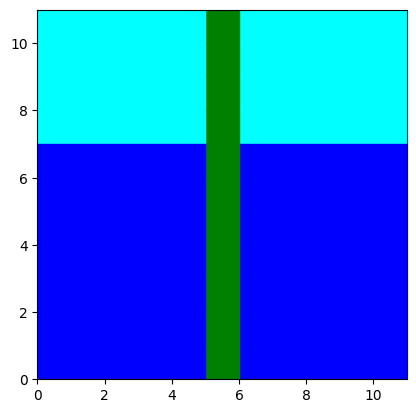

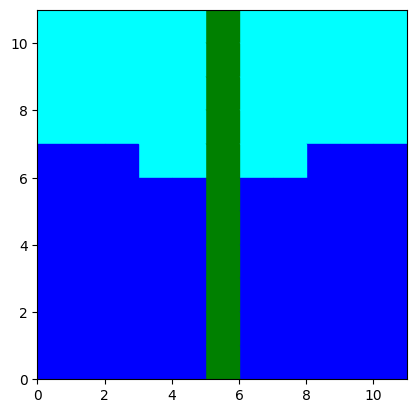

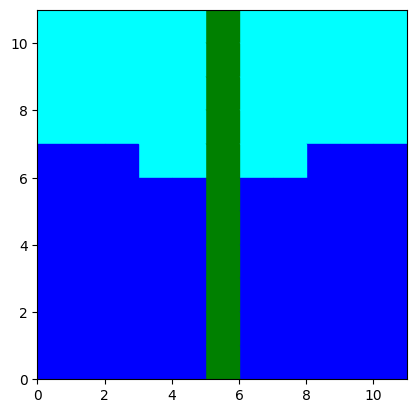

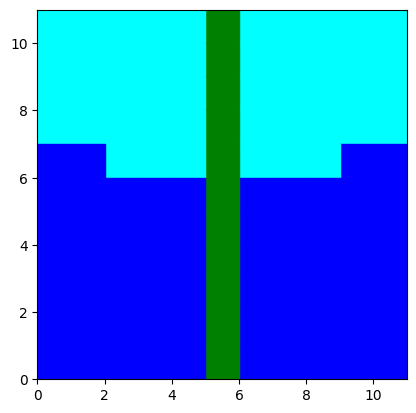

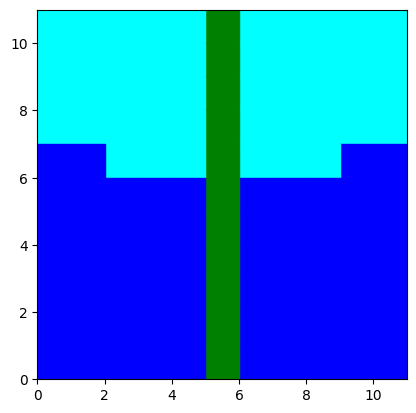

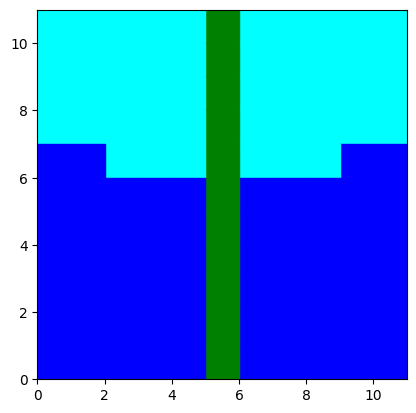

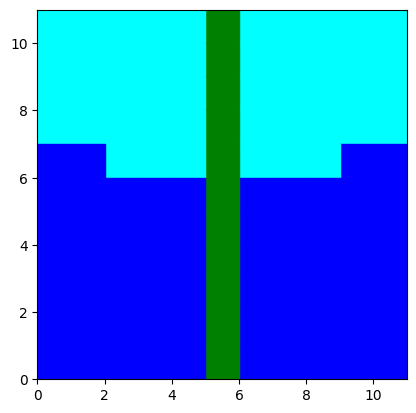

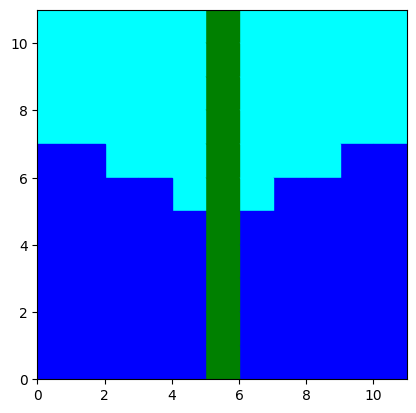

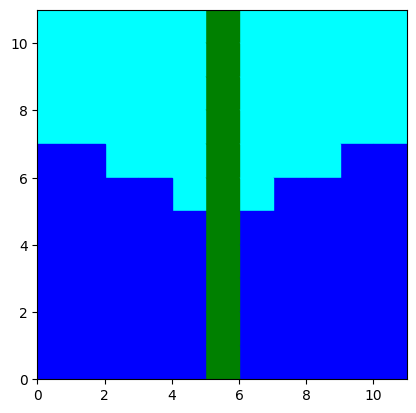

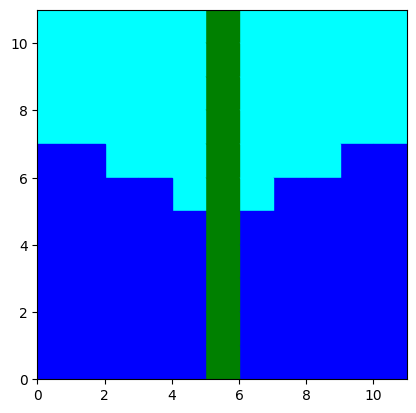

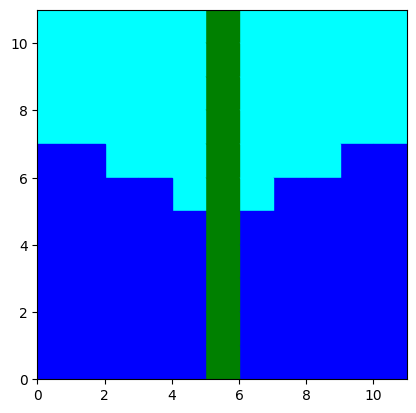

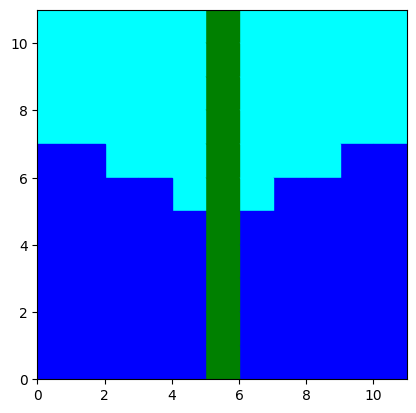

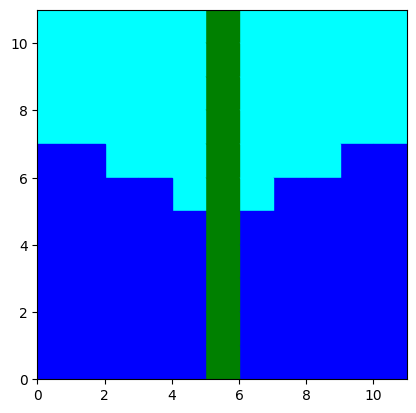

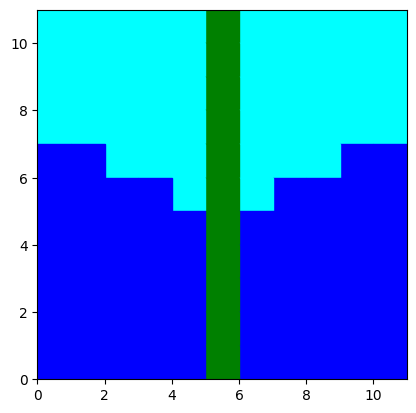

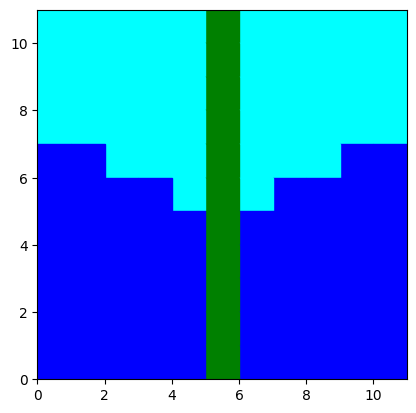

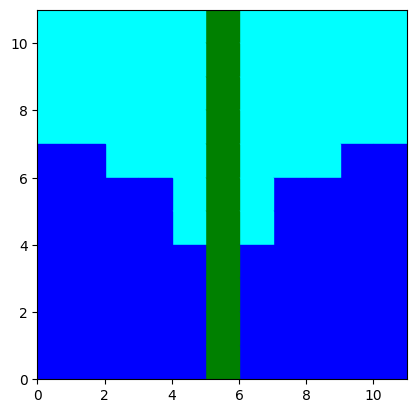

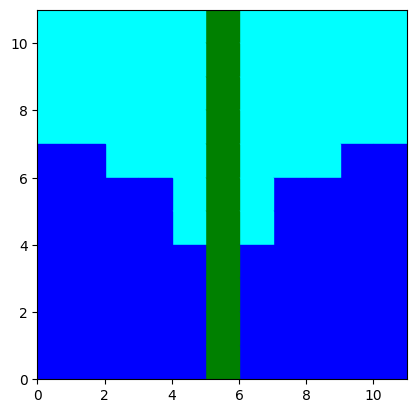

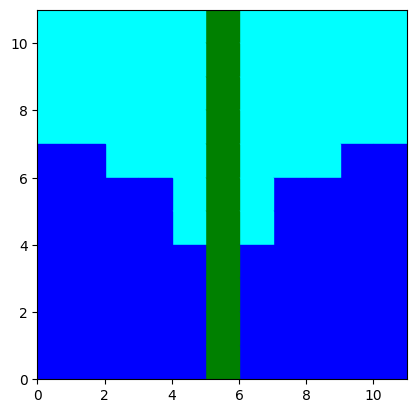

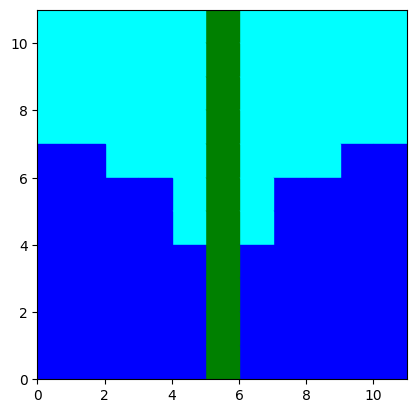

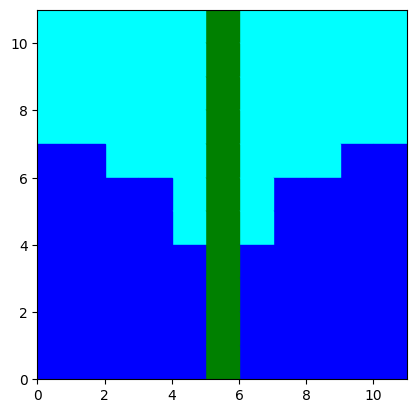

In [26]:
simulation_jolie(A, disp = "State")